# Traditional Word Embedding (tf/idf)

## Load the dataset (IMDB)

In [2]:
!wget -q https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [3]:
!tar -xf aclImdb_v1.tar.gz

In [6]:
import os
import pandas as pd

# Function to read files and create a dataframe
def load_imdb_data(data_dir):
    reviews = []
    labels = []
    for label_type in ['pos', 'neg']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    reviews.append(f.read())
                    labels.append(1 if label_type == 'pos' else 0)
    return pd.DataFrame({'review': reviews, 'label': labels})

# Load training data
df = load_imdb_data('aclImdb/train')


In [14]:
df.iloc[0].values


array(["Cameron Grant is one of the best directors doing adult films. His only rival is Andrew Blake. Celeste is dynamite all thru the movie but the DR's office sequence with her & two other ladies is just incredible. Nearly as good is Asia Carrera's performance with the construction worker. I highly recommend this movie & gave it a 9. It's almost as good as Cameron Grant's ELEMENTS OF DESIRE which I gave a 10.",
       1], dtype=object)

## Preprocessing

In [7]:
import re

# Clean the text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text


df['review'] = df['review'].apply(clean_text)
df.iloc[0].values


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'],
                                                    test_size=0.2, random_state=42)


## Word Embedding

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, and transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_tfidf, y_train)


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [25]:
# Sample reviews
sample_reviews = [
    "I love this product, it's absolutely amazing!",
    "This was a waste of money, I regret buying it.",
    "It's okay, not great but not bad either.",
    "The food was terrible and the service was even worse.",
    "Fantastic! I had a wonderful time.",
    "The product is below average, I wouldn't recommend it.",
    "Not the worst I've seen, but it definitely needs improvements.",
    "I really enjoyed the product; it works well and has great features, though I wish the setup was a bit easier."
]

# Clean and vectorize the samples
sample_reviews_cleaned = [clean_text(review) for review in sample_reviews]
sample_reviews_tfidf = tfidf_vectorizer.transform(sample_reviews_cleaned)

# Predict sentiment
sample_predictions = logistic_model.predict(sample_reviews_tfidf)

# Map predictions to sentiment labels
sentiment_map = {0: 'Negative', 1: 'Positive'}
predicted_sentiments = [sentiment_map[pred] for pred in sample_predictions]

# Show results
for review, sentiment in zip(sample_reviews, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: I love this product, it's absolutely amazing!
Predicted Sentiment: Positive

Review: This was a waste of money, I regret buying it.
Predicted Sentiment: Negative

Review: It's okay, not great but not bad either.
Predicted Sentiment: Negative

Review: The food was terrible and the service was even worse.
Predicted Sentiment: Negative

Review: Fantastic! I had a wonderful time.
Predicted Sentiment: Positive

Review: The product is below average, I wouldn't recommend it.
Predicted Sentiment: Negative

Review: Not the worst I've seen, but it definitely needs improvements.
Predicted Sentiment: Negative

Review: I really enjoyed the product; it works well and has great features, though I wish the setup was a bit easier.
Predicted Sentiment: Positive



## Word2Vec

In [4]:
from sklearn.datasets import load_files

dataset = load_files('aclImdb/train', categories=['pos', 'neg'], shuffle=True, random_state=42)
X, y = dataset.data, dataset.target


In [12]:
# Convert to DataFrame for easier handling
df = pd.DataFrame({'review': X, 'label': y})
df['review'] = df['review'].apply(lambda x: x.decode('utf-8'))


In [13]:
# Clean the text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

df['review'] = df['review'].apply(clean_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [14]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from gensim.models import Word2Vec


# Tokenize the reviews
X_train_tokens = [word_tokenize(review) for review in X_train]
X_test_tokens = [word_tokenize(review) for review in X_test]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=1)
# Save the model for later use
word2vec_model.save("word2vec.model")


In [18]:
import numpy as np
# Function to compute average Word2Vec embeddings for each review
def get_average_word2vec(tokens, model, vector_size):
    valid_words = [model.wv[word] for word in tokens if word in model.wv]
    if len(valid_words) == 0:
        return np.zeros(vector_size)
    return np.mean(valid_words, axis=0)


# Compute average word embeddings for training and testing sets
X_train_vectors = np.array([get_average_word2vec(tokens, word2vec_model, 100) for tokens in X_train_tokens])
X_test_vectors = np.array([get_average_word2vec(tokens, word2vec_model, 100) for tokens in X_test_tokens])


In [19]:
# Train Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_vectors, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_vectors)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8682
Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      2516
    Positive       0.86      0.88      0.87      2484

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion Matrix:
[[2162  354]
 [ 305 2179]]


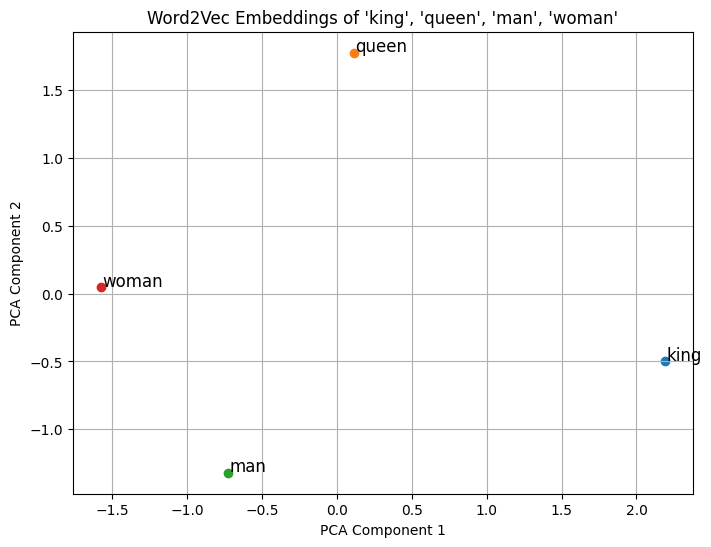

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Words to visualize
words = ["king", "queen", "man", "woman"]

# Get the word vectors for each of the words
word_vectors = [word2vec_model.wv[word] for word in words]


# Reduce dimensions using PCA for 2D visualization
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# Plot the vectors
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1])
    plt.annotate(word, (word_vecs_2d[i, 0] + 0.01, word_vecs_2d[i, 1] + 0.01), fontsize=12)

plt.title("Word2Vec Embeddings of 'king', 'queen', 'man', 'woman'")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()


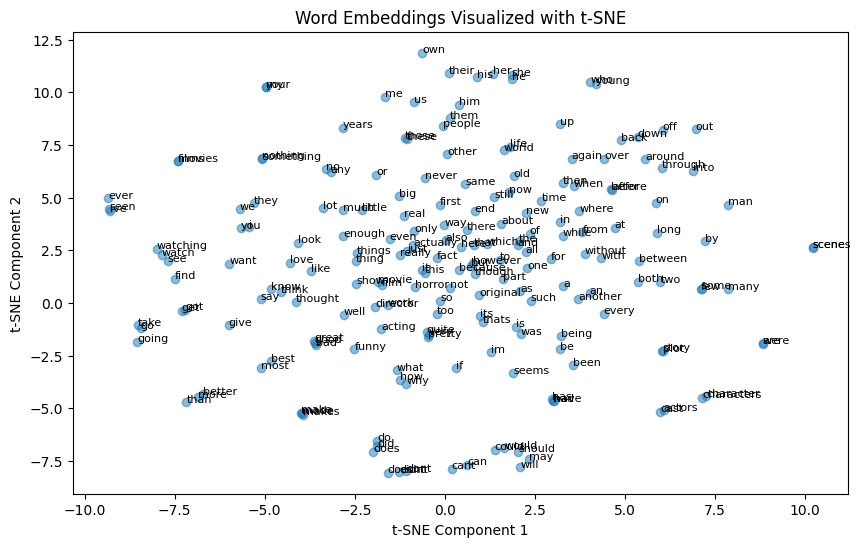

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get word vectors for visualization
words = list(word2vec_model.wv.index_to_key)
word_vectors = word2vec_model.wv[words]

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vecs_2d = tsne.fit_transform(word_vectors[:200])  # Only visualize 200 words for clarity

# Plot t-SNE diagram
plt.figure(figsize=(10, 6))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], alpha=0.5)
for i, word in enumerate(words[:200]):
    plt.annotate(word, (word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=8)
plt.title('Word Embeddings Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [22]:
# Sample reviews
sample_reviews = [
    "I love this product, it's absolutely amazing!",
    "This was a waste of money, I regret buying it.",
    "It's okay, not great but not bad either.",
    "The food was terrible and the service was even worse.",
    "Fantastic! I had a wonderful time.",
    "The product is below average, I wouldn't recommend it.",
    "Not the worst I've seen, but it definitely needs improvements.",
    "I really enjoyed the product; it works well and has great features, though I wish the setup was a bit easier."
]

# Tokenize and convert samples to vectors
sample_tokens = [word_tokenize(clean_text(review)) for review in sample_reviews]
sample_vectors = np.array([get_average_word2vec(tokens, word2vec_model, 100) for tokens in sample_tokens])

# Predict sentiment
sample_predictions = logistic_model.predict(sample_vectors)

# Map predictions to sentiment labels
sentiment_map = {0: 'Negative', 1: 'Positive'}
predicted_sentiments = [sentiment_map[pred] for pred in sample_predictions]

# Show results
for review, sentiment in zip(sample_reviews, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")



Review: I love this product, it's absolutely amazing!
Predicted Sentiment: Positive

Review: This was a waste of money, I regret buying it.
Predicted Sentiment: Negative

Review: It's okay, not great but not bad either.
Predicted Sentiment: Negative

Review: The food was terrible and the service was even worse.
Predicted Sentiment: Negative

Review: Fantastic! I had a wonderful time.
Predicted Sentiment: Positive

Review: The product is below average, I wouldn't recommend it.
Predicted Sentiment: Negative

Review: Not the worst I've seen, but it definitely needs improvements.
Predicted Sentiment: Negative

Review: I really enjoyed the product; it works well and has great features, though I wish the setup was a bit easier.
Predicted Sentiment: Positive



## Transform-based Models (BERT)

In [ ]:
!pip install datasets

In [24]:
from datasets import load_dataset

# Load the Yelp review dataset (it has 5 levels: 1-5)
dataset = load_dataset("yelp_review_full")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [25]:
from transformers import pipeline

# Load a pre-trained BERT sentiment-analysis model
sentiment_analyzer = pipeline("sentiment-analysis",
                              model="nlptown/bert-base-multilingual-uncased-sentiment")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [27]:
custom_reviews = [
    "I love this product, it's absolutely amazing!",
    "This was a waste of money, I regret buying it.",
    "It's okay, not great but not bad either.",
    "The food was terrible and the service was even worse.",
    "Fantastic! I had a wonderful time.",
    "The product is below average, I wouldn't recommend it.",
    "Not the worst I've seen, but it definitely needs improvements.",
    "I really enjoyed the product; it works well and has great features, though I wish the setup was a bit easier."

]

# Analyze sentiment for custom reviews
for text in custom_reviews:
    sentiment = sentiment_analyzer(text)
    print(f"Review: {text}\nSentiment: {sentiment}\n")


Review: I love this product, it's absolutely amazing!
Sentiment: [{'label': '5 stars', 'score': 0.9639626145362854}]

Review: This was a waste of money, I regret buying it.
Sentiment: [{'label': '1 star', 'score': 0.8563737273216248}]

Review: It's okay, not great but not bad either.
Sentiment: [{'label': '3 stars', 'score': 0.8735297322273254}]

Review: The food was terrible and the service was even worse.
Sentiment: [{'label': '1 star', 'score': 0.7131674885749817}]

Review: Fantastic! I had a wonderful time.
Sentiment: [{'label': '5 stars', 'score': 0.9448420405387878}]

Review: The product is below average, I wouldn't recommend it.
Sentiment: [{'label': '2 stars', 'score': 0.5625883340835571}]

Review: Not the worst I've seen, but it definitely needs improvements.
Sentiment: [{'label': '3 stars', 'score': 0.7497788667678833}]

Review: I really enjoyed the product; it works well and has great features, though I wish the setup was a bit easier.
Sentiment: [{'label': '4 stars', 'score